# **Example PSI Model Synthesis Notebook**

Tom Schad 

----

- This notebook does an example synthesis of the Thomson scattered corona (i.e the K-corona) using a global corona model from Predictive Sciences (PSI-MAS) 

----

In [1]:

##########  For parallel processing it is helpful to set some environmental variables to reduce threads in numpy libraries
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
os.environ['NUMEXPR_MAX_THREADS'] = '1'

import numpy as np
import multiprocessing
import tqdm
from scipy.interpolate import RegularGridInterpolator as rgi

##  https://github.com/tschad/pycelp
import pycelp 
import pycelp.allenSolRad as allen
import psi

# https://sunpy.org/
import sunpy
import sunpy.map
import sunpy.coordinates.sun as sun
import sunpy.sun.constants as constants
from sunpy.coordinates.ephemeris import get_horizons_coord
from sunpy.coordinates import frames
from sunpy.coordinates import sun
from astropy.coordinates import SkyCoord
from astropy.time  import Time,TimeDelta
from astropy.coordinates import EarthLocation, AltAz
from astropy import units as u


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["image.origin"]='lower'   ## have to worry about flips? 
plt.rcParams["image.interpolation"]='nearest'
from matplotlib.colors import LogNorm

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz
from matplotlib.colors import PowerNorm,SymLogNorm
from matplotlib.image import NonUniformImage


## **Create an instance of the psi.Model class to load and interact with PSI coronal model data**

- Models used here were downloaded using this website from [Predictive Sciences](https://www.predsci.com/hmi/data_access.php)
- We picked the date of the US total solar eclipse (21 Aug 2017) using the med-cor-thermo2 model for this demonstration.  

In [2]:
## https://www.predsci.com/data/runs/cr2194-medium/hmi_mast_mas_std_0201/
## carrington rotation 2194
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = psi.Model('/data/tschad/psiModels/21Aug2017_thermo2_12UTC/corona/')  

In [3]:
## return the instance name for some basic information on the class
corona

psi Model class
    ---------------------
    Data Directory Names: /data/tschad/psiModels/21Aug2017_thermo2_12UTC/corona/
    Number of longitude samples: 181
    Number of latitude samples: 100
    Number of radial samples: 150
    Data shape: (181, 100, 150)
    
    Variables: 
    lons -- Longitudes [rad]
    lats -- Latitudes [rad]
    rs   -- Radial samples [solar radii units]
    temp -- temperature [K]
    ne -- electron density [cm^-3]
    bx,by,bz  -- Cartesian components of magnetic field [G]
    vx,vy,vz  -- Cartesian components of velocity field [km/s]
    bmag      -- total magnetic field intensity [B]
    thetaBlocal -- location inclination of magnetic field in solar frame [rad]
    

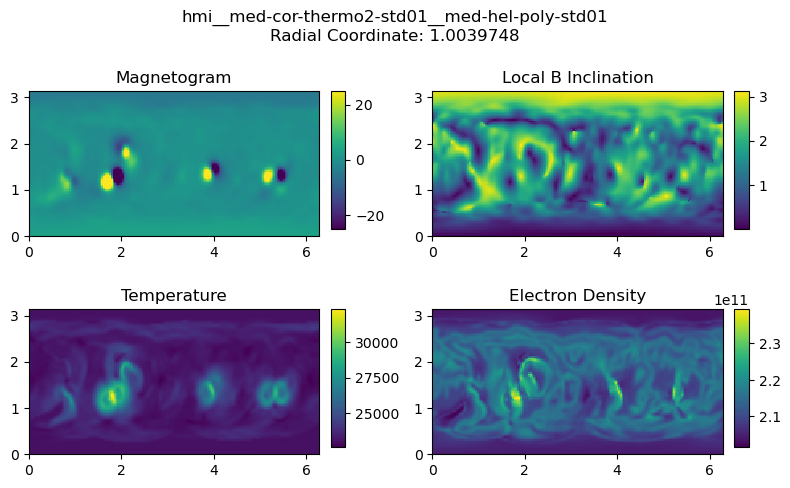

In [4]:
kk = 5

fig,ax = plt.subplots(2,2,figsize = (8,5))
ax = ax.flatten()
im0 = ax[0].imshow(corona.bmag[:,:,kk].T*np.cos(corona.thetaBlocal[:,:,kk]).T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[1].imshow(corona.thetaBlocal[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[2].imshow(corona.temp[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[3].imshow(corona.ne[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
labels = 'Magnetogram','Local B Inclination','Temperature','Electron Density'
for n in range(4): ax[n].set_title(labels[n])

im0.set_clim(-25,25)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]))

fig.tight_layout()

In [5]:
## Set up example Coordinates for an instrument (such as DKIST/CryoNIRSP) 

haleakala = EarthLocation(lat=20.706760*u.deg,
            lon=-(156.256262)*u.deg,
            height=3067.*u.m)

observerDKIST =SkyCoord(haleakala.get_gcrs(Time('2017-08-21T12:00:00.000')))
ff = frames.HeliographicCarrington(observer=observerDKIST)
rr = sunpy.coordinates.utils.get_limb_coordinates(observerDKIST)


In [6]:
from tqdm.auto import trange
latlon = np.zeros((2,len(rr)))
for n in trange(len(rr)):
    coord = rr[n]
    lc = coord.transform_to(ff)
    latlon[0,n] = lc.lat.rad
    latlon[1,n] = lc.lon.rad

sortlon = np.argsort(latlon[1,:])
latlon[0,:]= latlon[0,:][sortlon]
latlon[1,:]= latlon[1,:][sortlon]

  0%|          | 0/1000 [00:00<?, ?it/s]

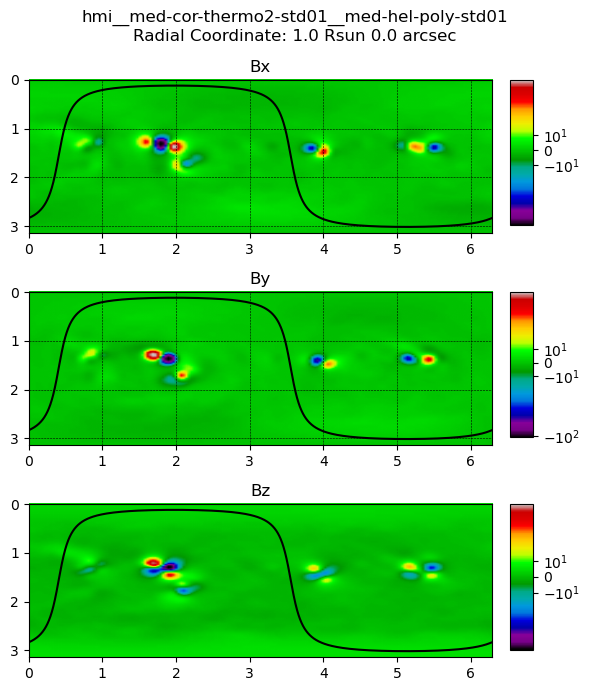

In [7]:
fig,ax = plt.subplots(3,1,figsize = (6,7))
ax = ax.flatten()
kk = 0

axi = ax[0]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi), cmap = 'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bx[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[1]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.by[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[2]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bz[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

for axi in ax: 
    axi.plot(latlon[1,:],-latlon[0,:]+np.pi/2.,'-',color = 'black')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    axi.set_ylim(np.pi,0)

ax[0].grid(ls = 'dashed',color = 'black',lw = 0.4)
ax[1].grid(ls = 'dashed',color = 'black',lw = 0.4)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]) + ' Rsun ' + str(np.round((corona.rs[kk]-1)*960.,2)) + ' arcsec')

ax[0].set_title('Bx')
ax[1].set_title('By')
ax[2].set_title('Bz')

clim = np.max(np.abs(im.get_clim()))
im.set_clim(-clim,clim)

fig.tight_layout()

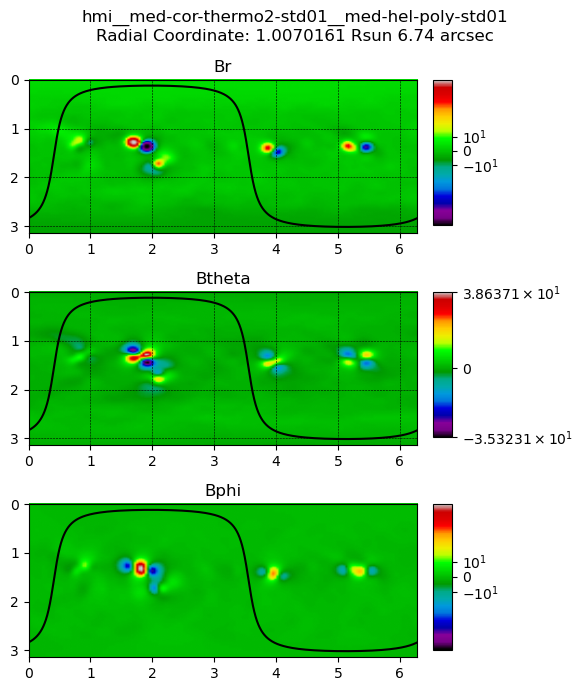

In [8]:
fig,ax = plt.subplots(3,1,figsize = (6,7))
ax = ax.flatten()
kk = 10

axi = ax[0]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi), cmap = 'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.br[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[1]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bt[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

axi = ax[2]
im = NonUniformImage(axi, interpolation = 'bilinear',extent=(0,2.*np.pi,0,np.pi),cmap =  'nipy_spectral',norm = SymLogNorm(40))
im.set_data(corona.lons,corona.lats,corona.bp[:,:,kk].T)
axi.add_image(im)
axi.set_xlim(0,2.*np.pi)
axi.set_ylim(np.pi,0.)

for axi in ax: 
    axi.plot(latlon[1,:],-latlon[0,:]+np.pi/2.,'-',color = 'black')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    axi.set_ylim(np.pi,0)

ax[0].grid(ls = 'dashed',color = 'black',lw = 0.4)
ax[1].grid(ls = 'dashed',color = 'black',lw = 0.4)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]) + ' Rsun ' + str(np.round((corona.rs[kk]-1)*960.,2)) + ' arcsec')


ax[0].set_title('Br')
ax[1].set_title('Btheta')
ax[2].set_title('Bphi')

clim = np.max(np.abs(im.get_clim()))
im.set_clim(-clim,clim)

fig.tight_layout()

This is the GONG 2194_000 synoptic map 

<img src="https://gong.nso.edu/data/magmap/QR/mqj/201708/mrmqj170830/mrmqj170830t0205c2194_000.jpg" />

## **Setup forward synthesis geometry**

- This is set up to synthesize a FOV from an arbitrary observer's position, def

### Observer's Position

In [9]:
crn        = sun.carrington_rotation_number('2017-08-21T12:00:00.000')
crt        = sun.carrington_rotation_time(crn)
obsLon     = sun.L0(crt).rad
obsLat     = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc    = sun.angular_radius(crt).value  ## radius of sun in arcseconds .. later replace with sun ephemeris

print('Carrington Rotation Number:     ',crn)
print('Carrington Rotation Time:       ',crt)
print('Observers Longitude [deg]:      ',np.rad2deg(obsLon))
print('Observers Latitude [deg]:       ',np.rad2deg(obsLat))
print('Observers distance to Sun [AU]: ',Obs_Sun_AU)
print('Apparent solar radius [arcsec]: ',rsunarc)

Carrington Rotation Number:      2194.184510135986
Carrington Rotation Time:        2017-08-21 12:00:00.010
Observers Longitude [deg]:       293.57634954025457
Observers Latitude [deg]:        6.919906588300292
Observers distance to Sun [AU]:  1.0115931095084487
Apparent solar radius [arcsec]:  948.2380793963277


In [10]:
solar_rad_m, au_m = constants.radius.value,constants.astronomical_unit.value
rObs     = Obs_Sun_AU * (au_m/solar_rad_m)  ## rObs is the radial position of the observer in solar radii
thetaObs = np.pi/2. - obsLat   ## Observers latitude in the PSI model geometry (0 is the NorthPole)
phiObs   = obsLon ## Observers Lon in PSI model geometry  
## cartesian position of Observer in PSI model geometery (units of solar radii)
xObs,yObs,zObs = rObs*np.sin(thetaObs)*np.cos(phiObs),rObs*np.sin(thetaObs)*np.sin(phiObs),rObs*np.cos(thetaObs)
print(xObs,yObs,zObs)

86.3698803760321 -197.91548987913015 26.207798489824064


### Synthesized Field-of-View Size and Sampling

- The synthesis geometry will have the x axis pointed toward the observer.  Z is aligned with polar axis. 

In [11]:
yfov_range = (-3.*rsunarc,+3*rsunarc)
zfov_range = (-3.*rsunarc,+3*rsunarc)
arcsamp    = 20.  ## sampling in arcsecond

nysamp = int(np.ceil((yfov_range[1]-yfov_range[0])/arcsamp))
nzsamp = int(np.ceil((zfov_range[1]-zfov_range[0])/arcsamp))
yarc = np.linspace(yfov_range[0],yfov_range[1],nysamp)
zarc = np.linspace(zfov_range[0],zfov_range[1],nzsamp)
zza,yya  = np.meshgrid(zarc,yarc,indexing = 'ij')
rra = np.sqrt(yya**2. + zza**2.) 
mask_ondisk = 1.*(rra>rsunarc)    ## a mask where the field of view cross the solar disk

Text(0.5, 1.0, 'Starting X point')

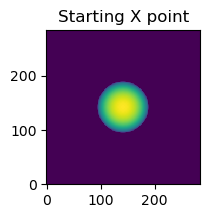

In [12]:
## First find the cartestian points of the reference point for the line of sight
## in the observer's geometry.  For offlimb points, this is the plane of the sky (yz). 
## On disk, these points should lie on the solar surface
xxObs = np.zeros_like(yya)
yyObs = rObs * np.tan(np.deg2rad(yya/3600.))
zzObs = rObs * np.tan(np.deg2rad(zza/3600.))
rrObs = np.sqrt(yyObs**2 + zzObs**2)
xxObs[rrObs<1] = np.sqrt(1 - rrObs[rrObs<1]**2) 
plt.figure(figsize = (2.5,2))
plt.imshow(xxObs)
plt.title('Starting X point')

In [13]:
## rotate these points into the model geometry with Euler rotation
rotm = euler_ry((thetaObs-np.pi/2.)) @ euler_rz(phiObs)
## earlier I had the rotation matrix as the transpose...not sure why..incorrect?
xyz_model = rotm  @ np.stack((xxObs.flatten(),yyObs.flatten(),zzObs.flatten())) 

## NOW WITH THE XYZ_MODEL POINTS AND THE LOCATION OF THE OBSERVER IN MODEL FRAME
## come up with the parametric equations for the los of sight
losvec    = np.stack((xObs-xyz_model[0,:],yObs-xyz_model[1,:],zObs - xyz_model[2,:]))
losveclen = np.linalg.norm(losvec,axis=0,ord=2,keepdims = True)
losvec    = losvec / losveclen
startpt   = xyz_model

In [14]:
lons,lats,rs = corona.lons,corona.lats,corona.rs
deltaR = (np.roll(rs,-1) - rs)[:(-1)]     ## using the radial sampling of the PSI model as the step size for the integration
deltaR = np.cumsum(deltaR)
deltaR = np.hstack((-np.flip(deltaR),deltaR))  ## both directions

In [15]:
rays_xyz = startpt[None,:,:] + (losvec * deltaR[:,None,None])
rays_xyz = np.swapaxes(rays_xyz,1,2)
print(rays_xyz.shape)

(298, 81225, 3)


In [16]:
nrays   = startpt.shape[1]
ray_npt = len(deltaR)
print('Number of rays to trace: ',nrays) 
print('Max number of samples per ray: ',ray_npt)

Number of rays to trace:  81225
Max number of samples per ray:  298


In [17]:
## get spherical coordinates of rays
rays_sph = np.zeros_like(rays_xyz)
rays_sph[:,:,0] = np.linalg.norm(rays_xyz,axis=2)        ## l2-norm 
rays_sph[:,:,1] = np.arccos(rays_xyz[:,:,2] / rays_sph[:,:,0])   ## arccos (z / r) 
rays_sph[:,:,2] = np.arctan2(rays_xyz[:,:,1] , rays_xyz[:,:,0])   ## arctan (y / x) 
rays_sph[:,:,2][rays_sph[:,:,2] <0] += 2.*np.pi ## so that it falls in the simulation domain 

In [18]:
print(startpt.shape,rays_sph.shape,rays_xyz.shape)
print(np.max(deltaR))

(3, 81225) (298, 81225, 3) (298, 81225, 3)
29.0


In [19]:
if 0: 
    print(rays_sph.shape)
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(rays_xyz[0,::10,0],rays_xyz[0,::10,1],rays_xyz[0,::10,2])
    ax.scatter3D(rays_xyz[ray_npt//2,::10,0],rays_xyz[ray_npt//2,::10,1],rays_xyz[ray_npt//2,::10,2])
    ax.scatter3D(rays_xyz[-1,::10,0],rays_xyz[-1,::10,1],rays_xyz[-1,::10,2])

    ax.scatter3D(xObs,yObs,zObs,'x',color = 'black') ## cartesian position of Observer in PSI model geometery (units of solar radii)
    ax.plot3D([0,xObs],[0,yObs],[0,zObs],ls = 'dashdot',color  = 'black')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim(-5,5)

    plt.figure(figsize = (6,4))
    plt.scatter(rays_xyz[ray_npt//2,:,2], rays_xyz[ray_npt//2,:,1],c=rays_sph[ray_npt//2,:,0],s=0.5)  ## lons, lats
    plt.ylim(-1,1)

## **Interpolate model variables at ray samples**

In [20]:
rays_xyz = rays_xyz.reshape(ray_npt*nrays,3)
rays_sph = rays_sph.reshape(ray_npt*nrays,3)

In [21]:
#### Get interpolating functions for all necessary simulation data
#### the ccoefInt already has the density factors included
tempInt  = rgi((lons,lats,rs),corona.temp,method = 'linear',fill_value = 0.,bounds_error = False)
neInt    = rgi((lons,lats,rs),corona.ne,method = 'linear',fill_value = 0.,bounds_error = False)

In [22]:
def parallel_int(argin):
    iobj,i0,i1 = argin
    return iobj(rays_sph[i0:i1,::-1])
        
def interpolate_raypts(iobj_int): 
                       
    nproc = 3
    nptint = ray_npt*nrays
    nrays_per_proc = np.ceil(nptint/nproc).astype(int)
    args = []
    for n in range(nproc):
        i0,i1 = n*nrays_per_proc,  (n+1)*nrays_per_proc
        i1 = np.clip(i1,0,nptint)
        args.append((iobj_int,i0,i1))
    
    p =  multiprocessing.Pool(processes=nproc,maxtasksperchild = 1000) 
    rs = p.imap(parallel_int,args)
    p.close()
    
    var_rays = np.zeros(nptint)
    
    nargs = len(args)
    pbar = tqdm.tqdm(total=nargs, position=0, leave=True)
    for i,res in enumerate(rs):
        i0,i1 = args[i][1:]
        var_rays[i0:i1] = res 
        pbar.update()
    pbar.close()

    return var_rays

In [23]:
## get bx,by,bz in PSI geometry for all the ray points
## this is the step that takes the longest! 
temp_rays = interpolate_raypts(tempInt)
ne_rays = interpolate_raypts(neInt)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.70s/it]


In [24]:
temp_rays = temp_rays.reshape(ray_npt,nrays)
ne_rays = ne_rays.reshape(ray_npt,nrays)

In [25]:
rays_xyz = rays_xyz.reshape(ray_npt,nrays,3)
rays_sph = rays_sph.reshape(ray_npt,nrays,3)

In [26]:
## angle between losvec and the vector from disk center
thetaDClos = np.arccos( (np.sum(rays_xyz*losvec.T[None,:,:],axis=2)/rays_sph[:,:,0]).clip(min = -1,max=1))

1778279.410038923


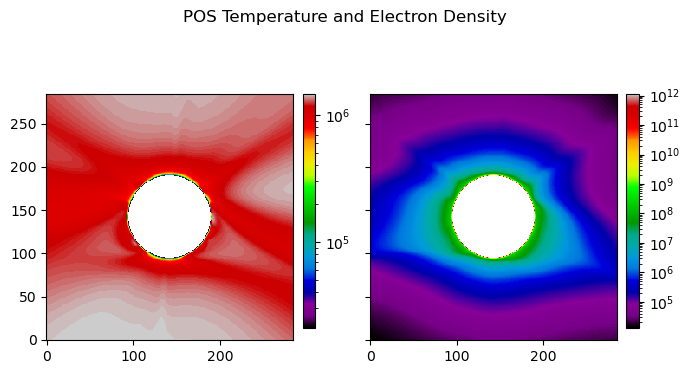

In [27]:
fig,ax = plt.subplots(1,2,figsize = (7,4),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(temp_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im1 = ax[1].imshow(ne_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))

print(10.**6.25)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle('POS Temperature and Electron Density')
fig.tight_layout()

## Forward Synthesize the Thomson Scattering

In [28]:
ht = (rays_sph[:,:,0]-1).clip(1.e-8) * constants.radius.value/1000.
ht = ht.reshape(ray_npt*nrays)
## CENTER PASSBAAND OF MLSO/COSMO/K-COR IS AT 7350 Angstrom 
## here using 10747 for Cryo Observations
J00 = allen.J00_sym(10747.,ht) 
units = J00[1]
print(units)
J00 = J00[0]
omega = allen.get_omega(10747.,ht)
Idc, Idc_unit = allen.i_nu(10747.,1.)

erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$


In [29]:
J00 = J00.reshape(ray_npt,nrays)
omega = omega.reshape(ray_npt,nrays)

In [30]:
## distance vector along the ray 
dray = deltaR[:,None] * constants.radius.value*100.  ## cm 
drayg = np.gradient(dray[:,0])

In [31]:
cc = 0.665e-24  ## total thomson scattering crosssection; units:: cm^2
## emission coefficients along line of sight (Equation 20 in Schad et al. 2022)
eps_rays = cc * ne_rays * J00 * (1 + omega/2 - (3./4.)*omega*np.sin(thetaDClos)**2)
Ithomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6  ## millionths of DC radiance 
eps_rays = - 3./4. * cc * ne_rays * omega * J00 * np.sin(thetaDClos)**2
pBthomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6 ## millionths of DC radiance 

/tmp/ipykernel_1256862/286178400.py:5: RuntimeWarning: invalid value encountered in divide
  im2 = ax[2].imshow(-pBthomson/Ithomson,cmap = plt.get_cmap('nipy_spectral'))


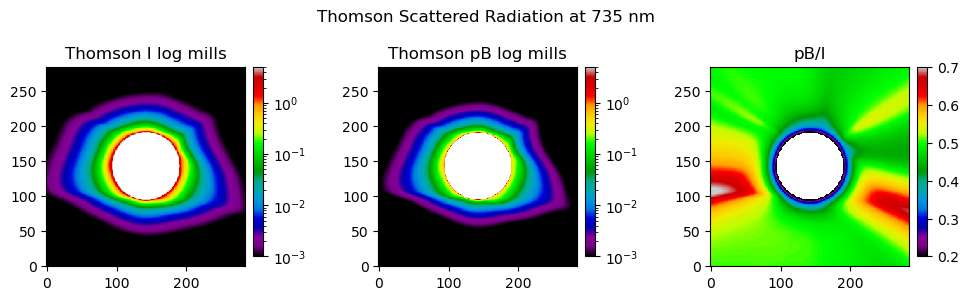

In [32]:
fig,ax = plt.subplots(1,3,figsize = (10,3.) )
ax = ax.flatten()
im0 = ax[0].imshow(Ithomson,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im1 = ax[1].imshow(-pBthomson,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'))
im2 = ax[2].imshow(-pBthomson/Ithomson,cmap = plt.get_cmap('nipy_spectral'))
im0.set_clim(0.001,5)
im1.set_clim(0.001,5)
im2.set_clim(0.2,0.7)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

ax[0].set_title('Thomson I log mills')
ax[1].set_title('Thomson pB log mills')
ax[2].set_title('pB/I')

fig.suptitle('Thomson Scattered Radiation at 735 nm')
fig.tight_layout()